<a href="https://colab.research.google.com/github/KillerGlass/deep-learning-in-pytroch/blob/main/MLP_com_augmentation_na_base_de_dados_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas


In [ ]:

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Carregando os dados

In [ ]:
torch.manual_seed(123)

In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.RandomHorizontalFlip(),#rodar imagens na horizontal
         transforms.RandomAffine(degrees = 7,#graus da imagem
                                 translate = (0, 0.07),#mundanças na horizontal e vertical
                                 shear =7,#cortes
                                 scale =  (1, 1.2)),#zoom 
         transforms.Normalize((0.5,), (0.5,)),
         ])

In [ ]:
train_aug = datasets.MNIST(root = '.', train=True, download=True, transform = transform)
train = datasets.MNIST(root = '.', train=True, download=True, transform = transforms.ToTensor())
test = datasets.MNIST(root = '.', train=False, download=True, transform = transforms.ToTensor())

In [ ]:
train.data.shape

torch.Size([60000, 28, 28])

In [ ]:
augmentation = torch.utils.data.ConcatDataset([train, train_aug])

In [ ]:
#aux = train_loader = torch.utils.data.DataLoader(augmentation,batch_size=200, shuffle=True)

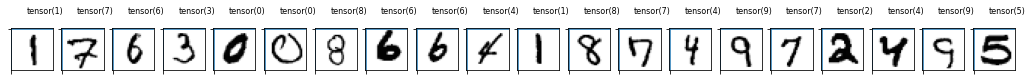

In [ ]:
#visualizar os numeros
count = 0
size = 20
plt.figure(figsize=(18, 10))
for i in np.random.permutation(train.data.shape[0])[:size]:
    count = count + 1
    plt.subplot(1, size, count)
    plt.axhline('')#retirar medidas do grafico
    plt.axvline('')
    plt.text(x=10, y=-10, s=train.targets[i], fontsize=8)
    plt.imshow(train.data[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

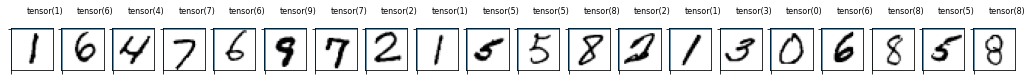

In [ ]:
#visualizar os numeros
count = 0
size = 20
plt.figure(figsize=(18, 10))
for i in np.random.permutation(train_aug.data.shape[0])[:size]:
    count = count + 1
    plt.subplot(1, size, count)
    plt.axhline('')#retirar medidas do grafico
    plt.axvline('')
    plt.text(x=10, y=-10, s=train_aug.targets[i], fontsize=8)
    plt.imshow(train_aug.data[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(augmentation,batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=128, shuffle=True)

# Construção do modelo

In [ ]:
class classficador_torch(nn.Module):

  def __init__(self):
    super().__init__()
    #criando as camadas convulocionais

    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 397),
      nn.ReLU(),
      nn.Linear(397, 397),
      nn.ReLU(),
      nn.Linear(397, 397),
      nn.ReLU(),
      nn.Linear(397, 10)
    )


  def forward(self,x):

    return self.layers(x)


In [ ]:
mlp = classficador_torch()

In [ ]:
criterio = nn.CrossEntropyLoss()#funçao de perda
optimizer = torch.optim.Adam(mlp.parameters())
#optimizer = torch.optim.SGD(mlp.parameters(),lr=0.001, momentum=0.9)

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
mlp.to(device)

classficador_torch(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=397, bias=True)
    (2): ReLU()
    (3): Linear(in_features=397, out_features=397, bias=True)
    (4): ReLU()
    (5): Linear(in_features=397, out_features=397, bias=True)
    (6): ReLU()
    (7): Linear(in_features=397, out_features=10, bias=True)
  )
)

# Treinamento do modelo

In [ ]:
mlp.train()

classficador_torch(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=397, bias=True)
    (2): ReLU()
    (3): Linear(in_features=397, out_features=397, bias=True)
    (4): ReLU()
    (5): Linear(in_features=397, out_features=397, bias=True)
    (6): ReLU()
    (7): Linear(in_features=397, out_features=10, bias=True)
  )
)

In [ ]:
def forward(model,optimizer,inputs,labels,mode):

  if mode == 'Training':
    optimizer.zero_grad()

  inputs , labels = inputs.to(device), labels.to(device)

  outputs = model(inputs)#classificador.forward é a mesma coisa, camada de aprendizado

  loss = criterio(outputs,labels)#calculando o err

  if mode == 'Training':
    loss.backward()
    optimizer.step()

  #calculando acuracia
  #softmax retorna uma probabilidade, k = 1 resultado de maior valor, dim = 1 processamento por coluna
  res_p, res_class = F.softmax(outputs).topk(k=1, dim = 1)
  #verificando se o classificador acertou ou errou, depois de fazer uma comparaçao entre os vetores de boleanos
  #se faz a media
  accuracy = torch.mean((res_class == labels.view(*res_class.shape)).type(torch.float))

  
  return model, loss, accuracy, optimizer

  

In [ ]:
for epoch in range(25):
  running_loss = 0
  running_acurracy = 0

  for i,data in enumerate(train_loader):
    #inputs sao entradas, previsores. Labels as respostas reais
    inputs, labels = data
    #zerando os gradientes. Gradientes é a direção para onde vai ser feito os ajustes do peso 

    mlp, loss, accuracy, optimizer = forward(mlp,optimizer,inputs,labels,"Training")

    running_loss += loss.item()

    running_acurracy += accuracy

    #print("Epocas: {}| Iteração {} | Loss: {:.5f} | Precisao {:03.2f}".format(epoch+1,i + 1, loss,accuracy))

  
  #a divisao ocorre para ter uma proporção de erro
  print("Epocas: {} | Loss: {:.5f}, Precisao {:03.2f}".format(epoch+1,running_loss/len(train_loader), running_acurracy/len(train_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epocas: 1 | Loss: 0.41886, Precisao 0.87
Epocas: 2 | Loss: 0.18100, Precisao 0.94
Epocas: 3 | Loss: 0.14070, Precisao 0.96
Epocas: 4 | Loss: 0.11809, Precisao 0.96
Epocas: 5 | Loss: 0.10246, Precisao 0.97
Epocas: 6 | Loss: 0.09640, Precisao 0.97
Epocas: 7 | Loss: 0.08673, Precisao 0.97
Epocas: 8 | Loss: 0.08056, Precisao 0.97
Epocas: 9 | Loss: 0.07559, Precisao 0.98
Epocas: 10 | Loss: 0.07201, Precisao 0.98
Epocas: 11 | Loss: 0.06972, Precisao 0.98
Epocas: 12 | Loss: 0.06578, Precisao 0.98
Epocas: 13 | Loss: 0.06342, Precisao 0.98
Epocas: 14 | Loss: 0.06012, Precisao 0.98
Epocas: 15 | Loss: 0.06079, Precisao 0.98
Epocas: 16 | Loss: 0.05672, Precisao 0.98
Epocas: 17 | Loss: 0.05526, Precisao 0.98
Epocas: 18 | Loss: 0.05208, Precisao 0.98
Epocas: 19 | Loss: 0.05295, Precisao 0.98
Epocas: 20 | Loss: 0.05301, Precisao 0.98
Epocas: 21 | Loss: 0.05101, Precisao 0.98
Epocas: 22 | Loss: 0.04926, Precisao 0.98
Epocas: 23 | Loss: 0.04695, Precisao 0.99
Epocas: 24 | Loss: 0.04643, Precisao 0.99
E

#Avaliação do modelo

In [ ]:
running_acurracy = 0
mlp.eval()
for i,data in enumerate(test_loader):
  #inputs sao entradas, previsores. Labels as respostas reais
  inputs, labels = data
  #zerando os gradientes. Gradientes é a direção para onde vai ser feito os ajustes do peso 

  mlp, loss, accuracy, optimizer = forward(mlp,optimizer,inputs,labels,"Test")

  running_loss += loss.item()

  running_acurracy += accuracy

print("Precisao {:03.2f}".format(running_acurracy/len(test_loader)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Precisao 0.99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


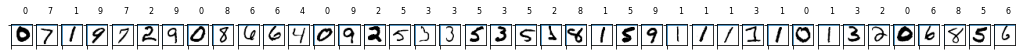

In [ ]:
#visualizar os resultados
images = []
count = 0
size = 40
plt.figure(figsize=(18, 10))
for i in range(40):
    imagem = next(iter(test_loader))[0][i].view(28,28)

    img = imagem.view(1,1,28,28)
    img = img.to(device)
    prev = mlp.forward(img)
    prev = F.softmax(prev)
    prev = np.argmax(prev.cpu().detach().numpy())
    
    count = count + 1
    plt.subplot(1, size, count)
    plt.axhline('')#retirar medidas do grafico
    plt.axvline('')
    plt.text(x=15, y=-15, s=prev, fontsize=8)
    plt.imshow(imagem.reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

In [1]:
torch.save(mlp.state_dict(), "mlp.pt")

NameError: ignored